In [28]:
import networkx as nx
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import sys
sys.path.insert(0, os.environ['PLOT_SETTINGS_DIR'])
import plot_settings

def gset_to_nx(fpath: str):
    G = nx.Graph()
    elist = []
    sumw = 0
    offset = 0 if '.gset' in fpath else 1
    with open(fpath, 'r') as f:
        u, v = f.readline().split()
        u = int(u)
        v = int(v)
        for line in f.readlines():
            args = line.strip().split()
            if len(args) < 2:
                continue
            if len(args) == 2:
                u, v = args
                u = int(u) + offset
                v = int(v) + offset
                elist.append((u, v))
                sumw += 1
                continue
            u, v, w = args
            w = float(w)
            u = int(u) + offset
            v = int(v) + offset
            sumw += w
            elist.append((u, v, w))
        if len(elist[0]) == 2:
            G.add_edges_from(elist)
        else:
            G.add_weighted_edges_from(elist)
    return G

In [29]:
import re

flist = filter(lambda x: '.csv' in x , os.listdir('../data'))
pattern = re.compile('b(\d+)_e(\d+)')
data = []
for fname in flist:
    blocks, epochs = 1, 1
    selection = 'cyclic'
    df = pd.read_csv(f'../data/{fname}')
    df['perturbation'] = 0.0
    if df['seed'].iloc[0] != 58888319060236145:
        continue
    if 'random' in fname:
        selection = 'random'
    if 'full_gradient' not in fname:
        blocks, epochs = map(int, pattern.findall(fname)[0])
        perturb = False
        selection = 'R' if 'random' in fname else 'C'
        df['Algorithm'] = f'{selection}BLD'
        if '_p_' in fname:
            pert = float(re.findall(r'_p_([\d\.]+)\.csv', fname)[0])
            if pert > 0.6:
                continue
            df['perturbation'] = pert
            # if int(round(pert * 10)) % 2 != 0:
            #     continue
    else:
        df['Algorithm'] = f'LD'
    df['epoch'] = epochs
    df['Blocks'] = blocks
    
    # df['Algorithm'] = f'{blocks}-'
    # df['selection'] = selection
    data.append(df)
df = pd.concat(data).reset_index(drop=True)
df['Time (s)'] = df['step'] * 1e-3 * (50e-15 * 31e4)
df['Rescaled Time (s / Block)'] = df['Time (s)'] / df['Blocks']
plot_df = df.query('step % 3600 == 0')
line_kwargs = dict(
markersize=12, markevery=10, palette='tab10', linewidth=3, linestyle='--', 
)


In [30]:
df1.query('Blocks == 2').query('step == 3600')

,Unnamed: 0,step,KL,W2,seed,perturbation,Algorithm,epoch,Blocks,Time (s),Rescaled Time (s / Block)
340120,120,3600,31.615778,27.538609,58888319060236145,0.0,CBLD,10,2,5.580000e-08,2.790000e-08


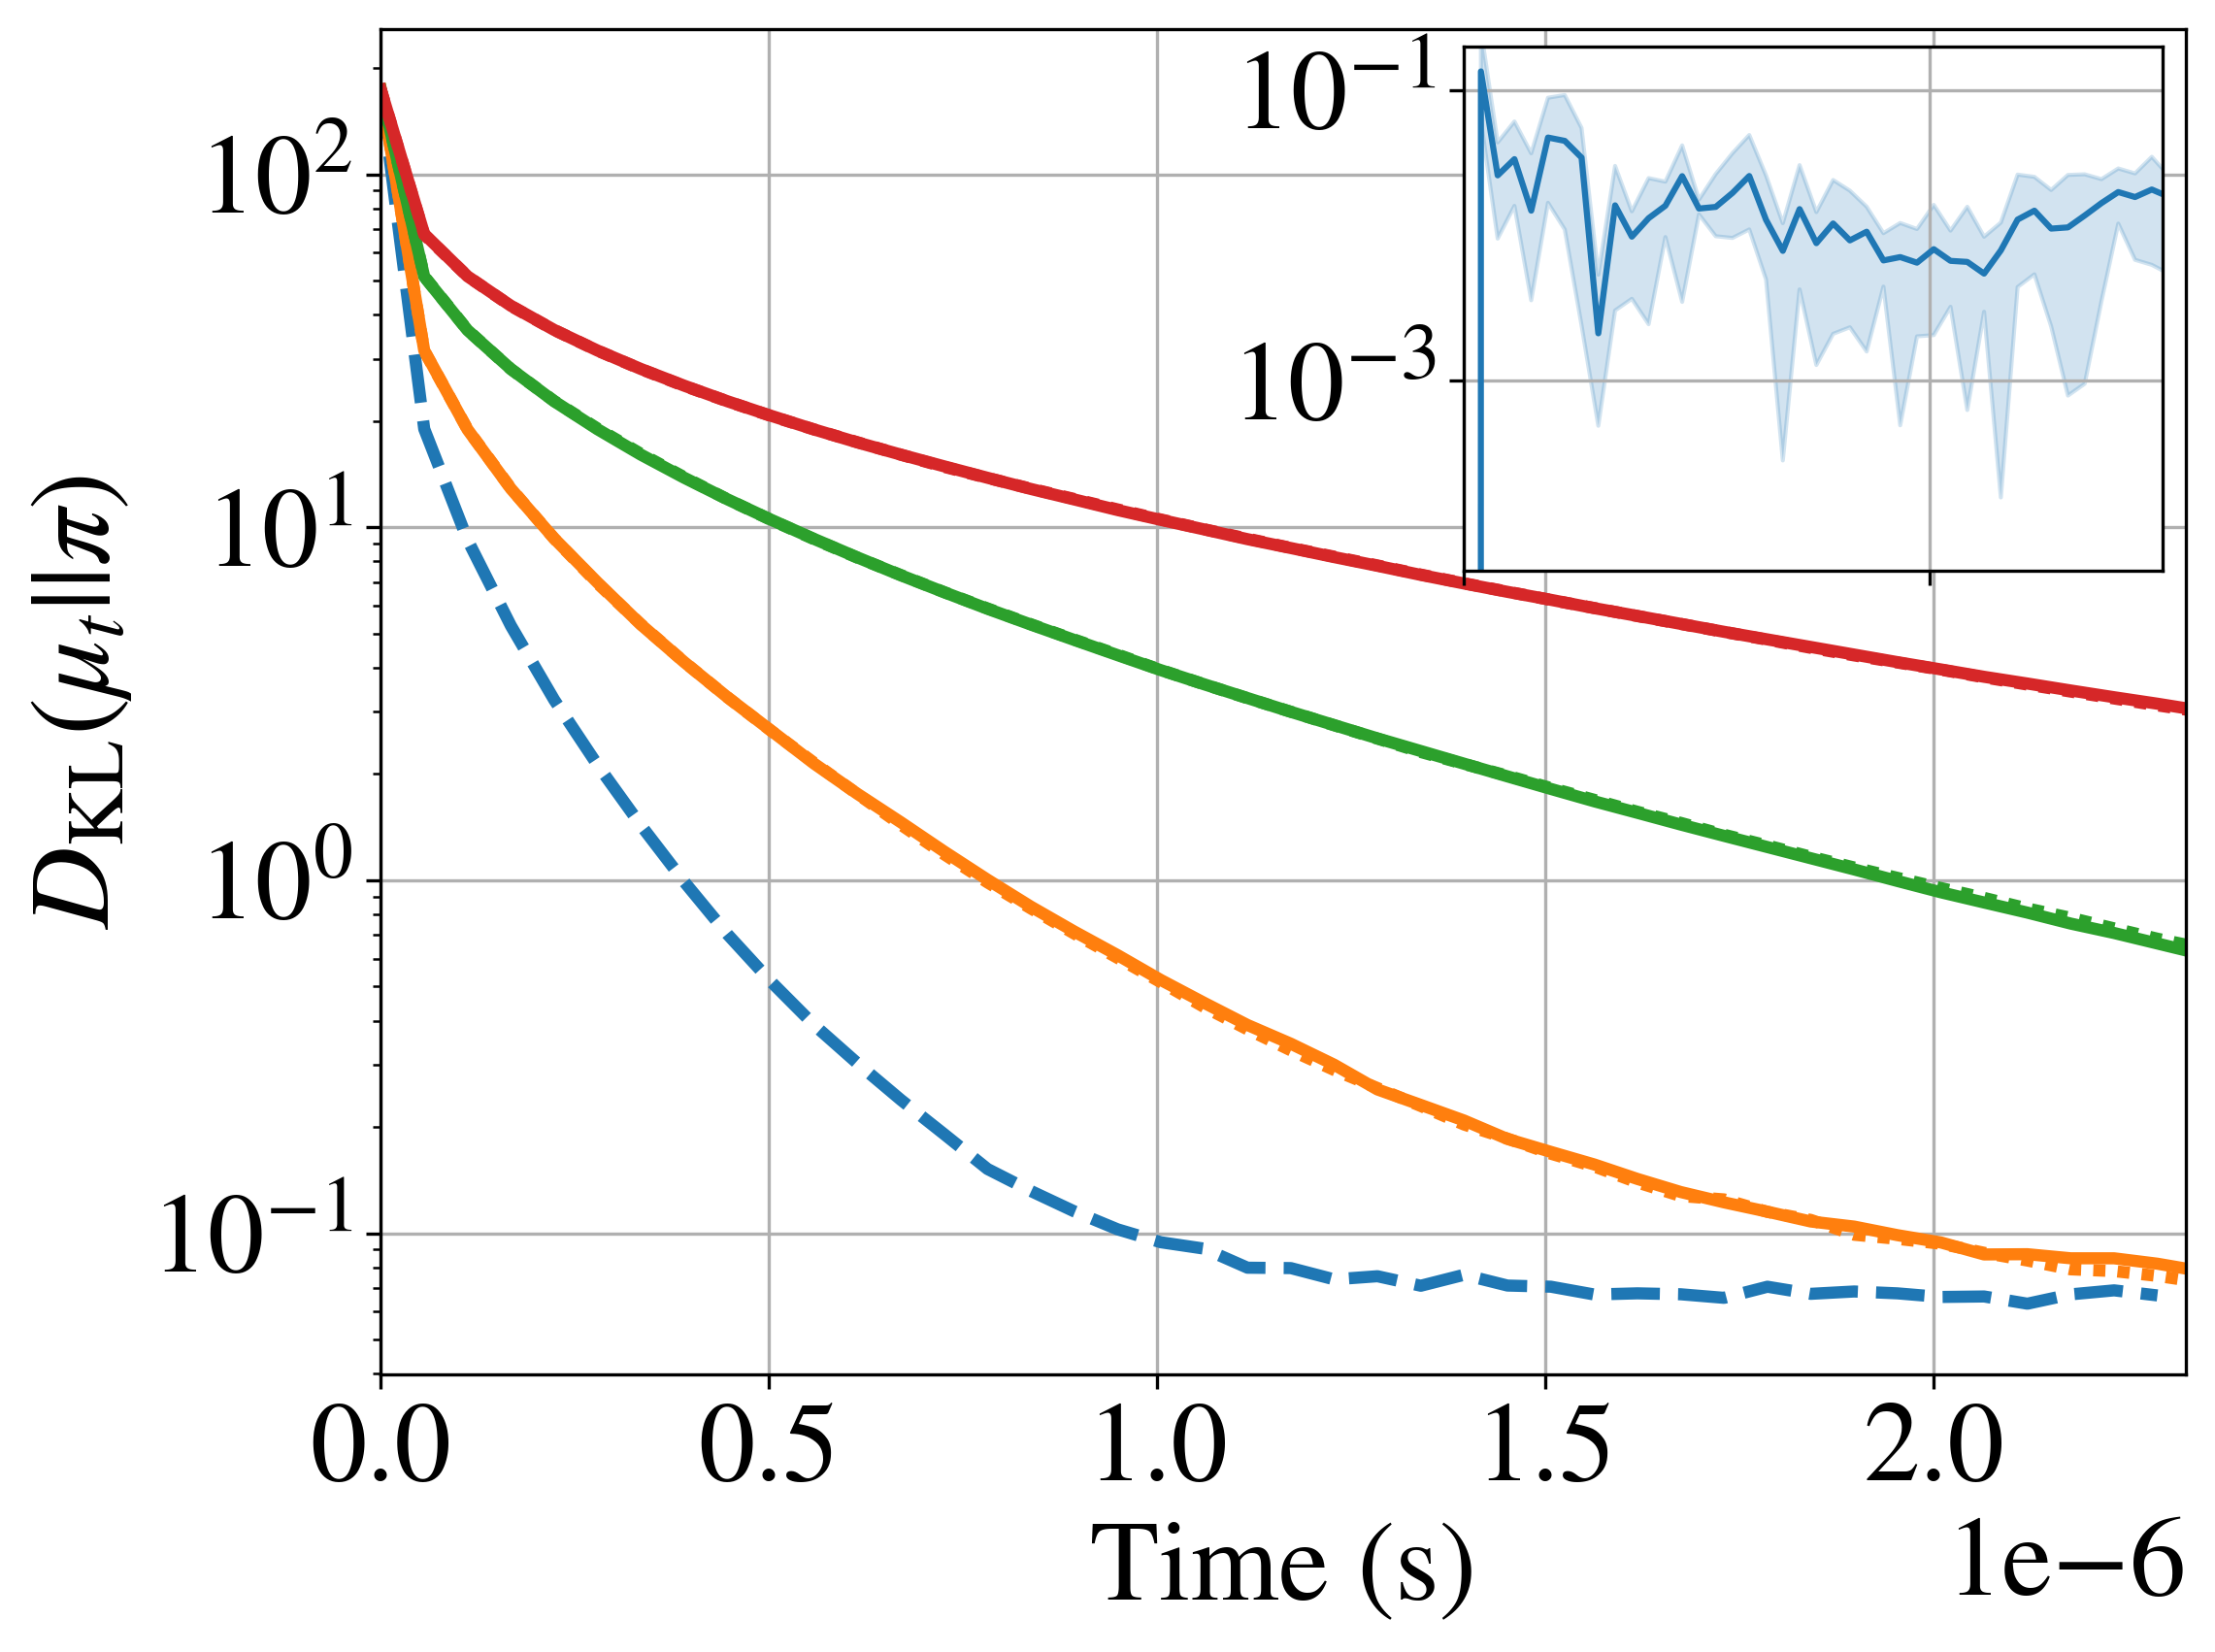

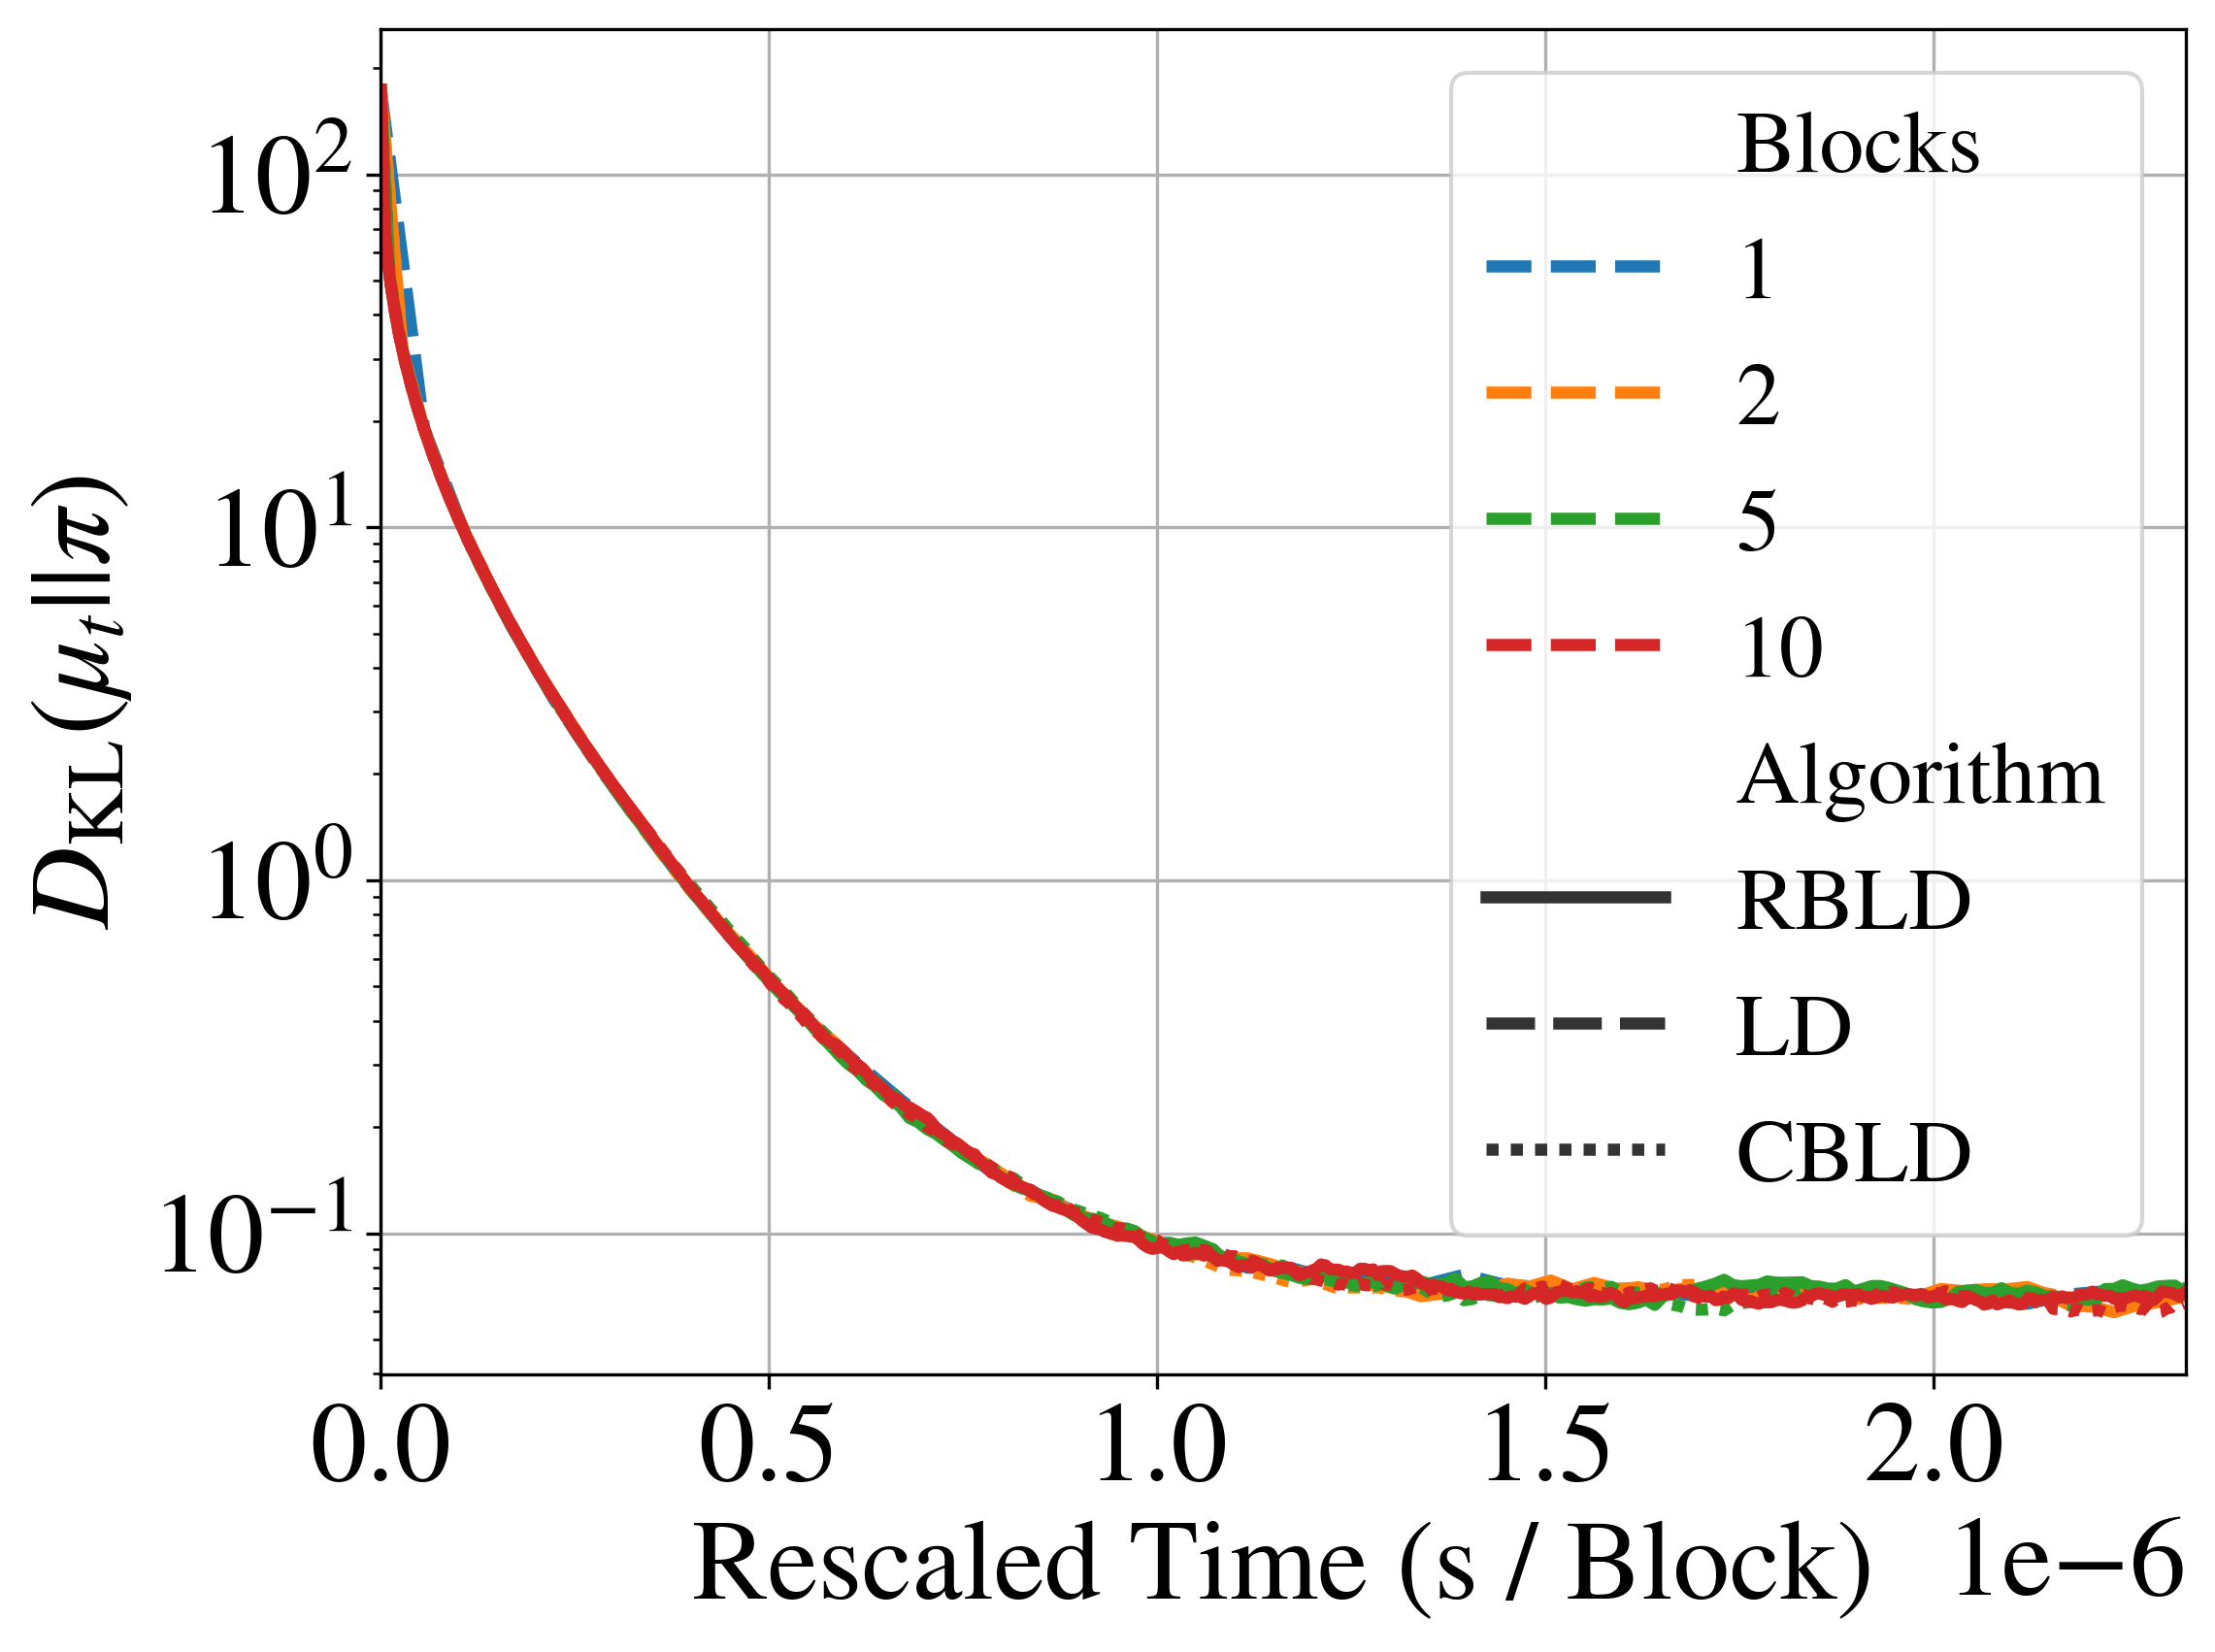

In [37]:
fig, ax = plt.subplots(figsize=(8,6))
lim_df = plot_df.query('(Blocks == 1 or (epoch == 10)) and perturbation == 0')
# y = 200*np.exp(-10e-5 * x * 5.6)
# # sns.lineplot(x=x, y=y)
df1 = lim_df.query('Algorithm == "CBLD"')
df2 = lim_df.query('Algorithm == "RBLD"')
comp = df1.merge(df2, on=['Blocks', 'step', 'epoch', 'perturbation'], suffixes=['_c', '_r'])
comp['comp'] = np.abs(comp['KL_c'] - comp['KL_r'])
sns.lineplot(lim_df,ax=ax, x='Time (s)', y='KL', hue='Blocks',style='Algorithm', **line_kwargs)
ax.set_xlim(0, 150000* 1e-3 * (50e-15 * 31e4))
left, bottom, width, height = [0.59, 0.57, 0.3, 0.3]
ax2 = fig.add_axes([left, bottom, width, height])
# ax2.set_yscale('log')
sns.lineplot(data=comp, x='step', y='comp')
ax2.set_xlabel('')
ax2.set_ylabel('')
ax2.set_xlim(0, 150000)
ax2.legend_ = None
ax2.set_xticklabels([])
ax2.set_yscale('log')
ax2.set_ylim(5e-5, 2e-1)
ax2.grid()
ax.set_yscale('log')
ax.legend_ = None
ax.grid()
ax.set_ylabel('$D_{\\text{KL}}(\\mu_t||\\pi)$')
fig.savefig('../figures/time_kl.pdf', bbox_inches='tight')
plt.show()
fig, ax = plt.subplots(figsize=(8,6))
sns.lineplot(lim_df,ax=ax, x='Rescaled Time (s / Block)', y='KL', hue='Blocks',style='Algorithm', **line_kwargs)
ax.set_xlim(0, 150000* 1e-3 * (50e-15 * 31e4))
ax.set_yscale('log')
ax.set_ylabel('$D_{\\text{KL}}(\\mu_t||\\pi)$')
ax.grid()
ax.legend(fontsize=22)
plt.show()
fig.savefig('../figures/block_time_kl.pdf', bbox_inches='tight')


/tmp/ipykernel_424189/302170030.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lim_df['$\\lambda (s)$'] = np.round(lim_df['epoch'] * 1e-3 * (50e-15 * 31e4), decimals = 11)


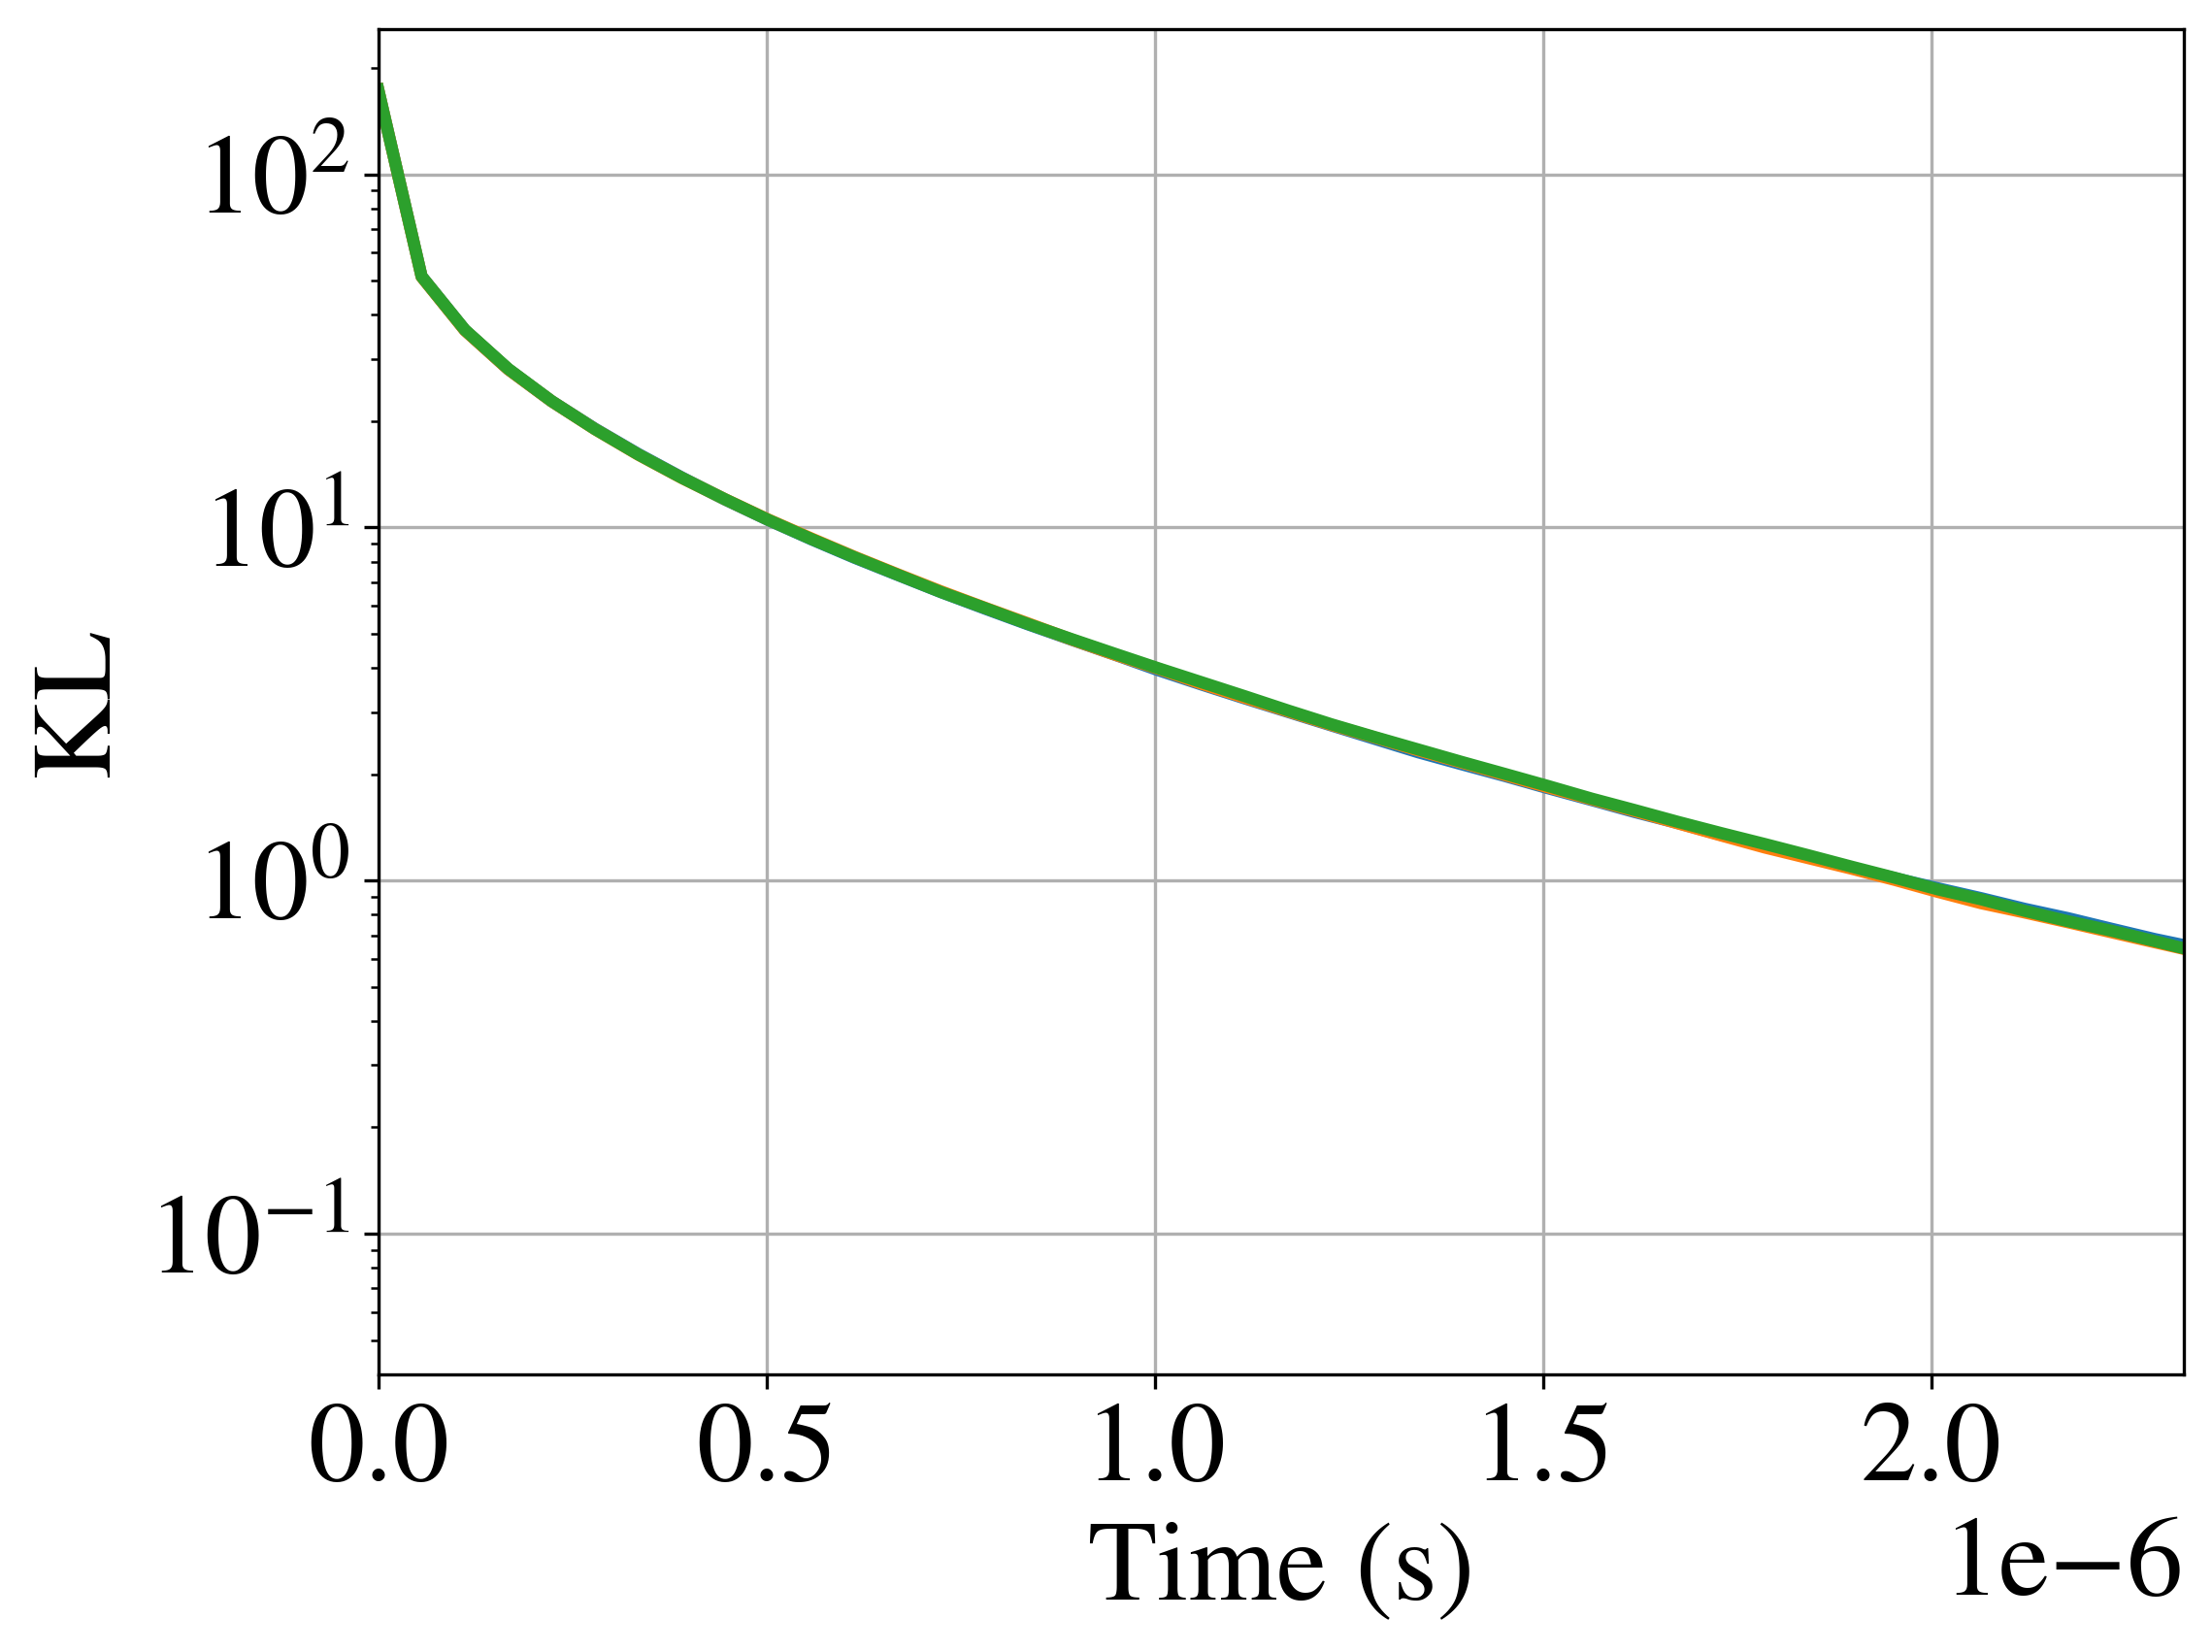

/tmp/ipykernel_424189/302170030.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lim_df['Cycle'] = lim_df.eval('step / (epoch * Blocks)')


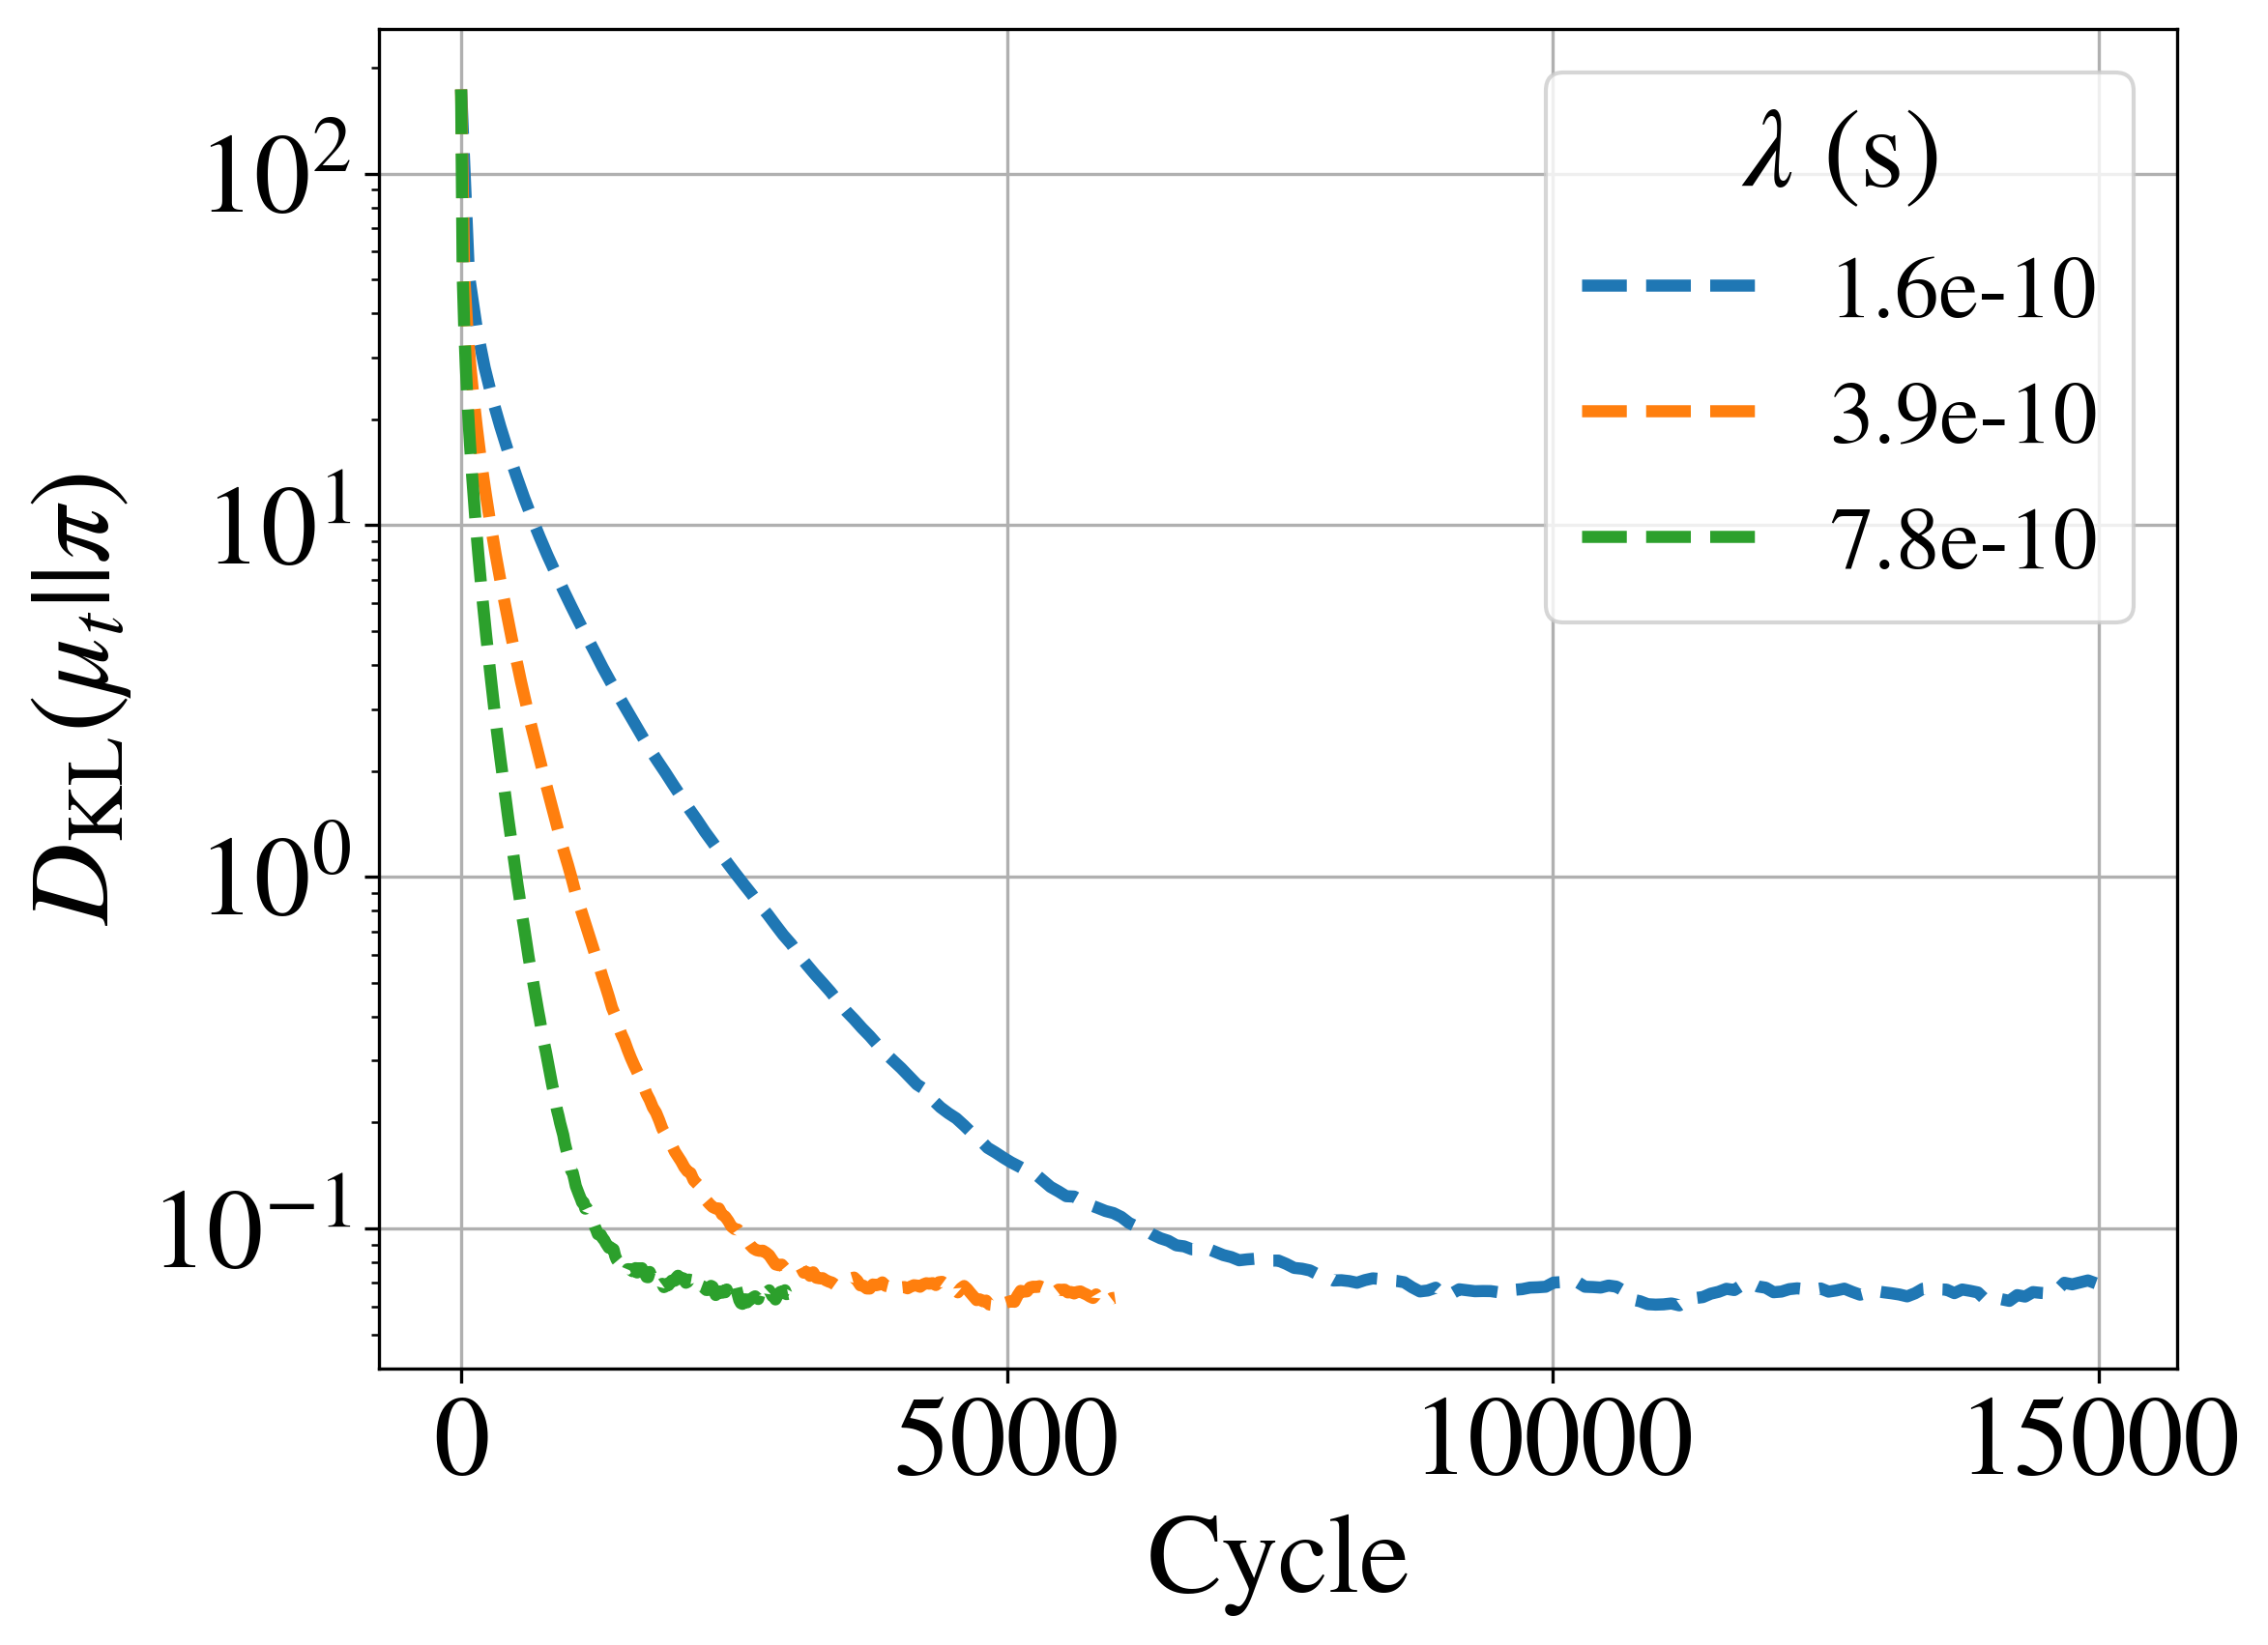

In [32]:
fig, ax = plt.subplots(figsize=(8,6))
lim_df = plot_df.query('(Blocks == 5) and Algorithm == "CBLD" and perturbation == 0')
# y = 200*np.exp(-10e-5 * x * 5.6)
# # sns.lineplot(x=x, y=y)
lim_df['$\\lambda (s)$'] = np.round(lim_df['epoch'] * 1e-3 * (50e-15 * 31e4), decimals = 11)
sns.lineplot(lim_df,ax=ax, x='Time (s)', y='KL', hue='$\\lambda (s)$',style='Algorithm', **line_kwargs)
ax.set_xlim(0, 150000* 1e-3 * (50e-15 * 31e4))
ax.set_yscale('log')
ax.legend_ = None
ax.grid()
plt.show()
# lim_df['Rescaled Epoch Time']
lim_df['Cycle'] = lim_df.eval('step / (epoch * Blocks)')
fig, ax = plt.subplots(figsize=(8,6))
sns.lineplot(lim_df,ax=ax, x='Cycle', y='KL', hue='$\\lambda (s)$', **line_kwargs)
# ax.set_xlim(0, 150000)
ax.set_yscale('log')
ax.set_ylabel('$D_{\\text{KL}}(\\mu_t||\\pi)$')
ax.grid()
ax.legend(fontsize=22, title='$\\lambda$ (s)')
plt.show()
fig.savefig('../figures/step_kl.pdf', bbox_inches='tight')

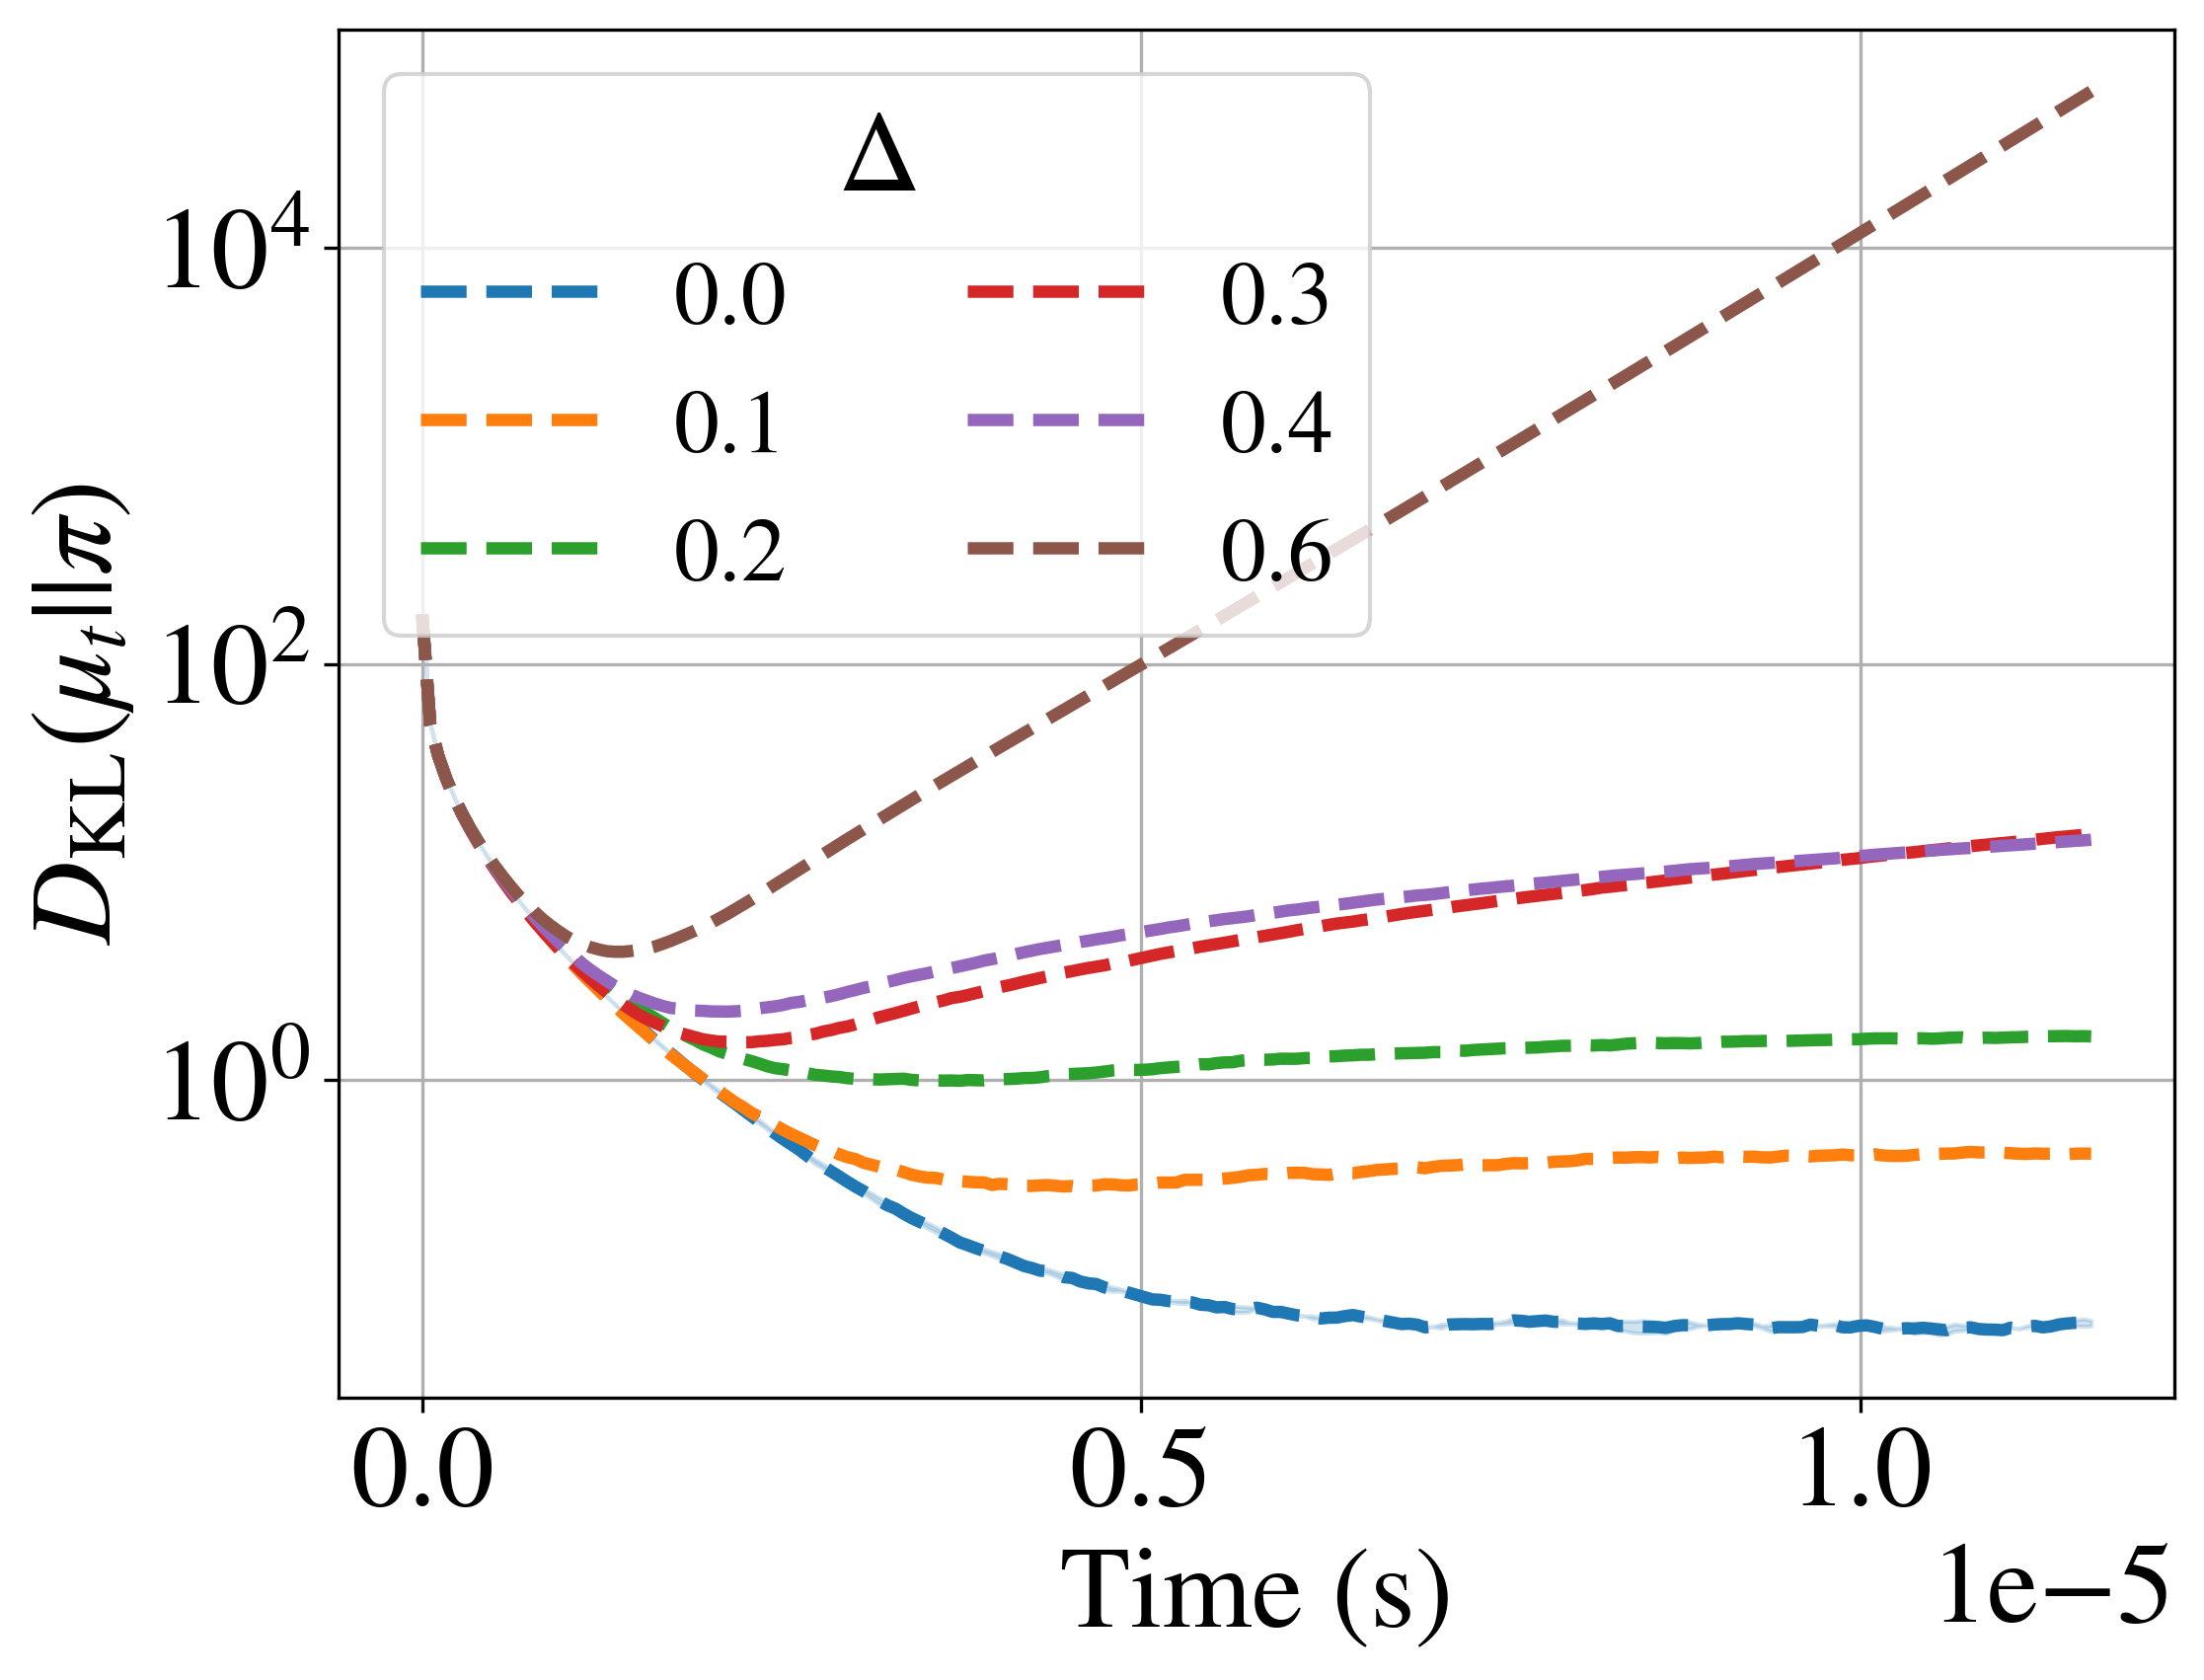

In [13]:
fig, ax = plt.subplots(figsize=(8,6))
lim_df = plot_df.query('(Blocks == 5 and epoch == 10) and Algorithm == "CBLD" and perturbation <= 0.6').rename(columns={'perturbation': "$\\Delta$"})
# y = 200*np.exp(-10e-5 * x * 5.6)
# # sns.lineplot(x=x, y=y)
sns.lineplot(lim_df,ax=ax, x='Time (s)', y='KL', hue='$\\Delta$', **line_kwargs)
# ax.set_xlim(0, 150000* 1e-3 * (50e-15 * 31e4))
ax.set_yscale('log')
ax.legend(title='$\\Delta$', ncols=2, fontsize=22)
ax.set_ylabel('$D_{\\text{KL}}(\\mu_t||\\pi)$')
ax.grid()
plt.show()
fig.savefig('../figures/perturbation_kl.pdf', bbox_inches='tight')